In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import timm
import cupy

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Define path to your training data
train_data_path = 'AugmentedAlzheimerDataset'
# Load dataset using ImageFolder and split into train and validation
train_dataset = ImageFolder(root=train_data_path, transform=transform)

In [6]:
# Assuming you want to split 80% for training and 20% for validation
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1*len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# # Load GhostNet model from PyTorch Hub
# ghostnet = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)

In [8]:
# Define the custom GhostNet model
class CustomGhostNet(nn.Module):
    def __init__(self, original_model, num_classes=4):  # Assuming 4 classes
        super(CustomGhostNet, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Remove the last layer
        self.custom_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),  # Adjusted dropout rate
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Adjusted dropout rate
            nn.Linear(128, num_classes),
            nn.LogSoftmax(dim=1)  # LogSoftmax layer for the final classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.custom_layers(x)
        return x

In [9]:
# Load GhostNet model from PyTorch Hub
ghostnet = torch.hub.load('huawei-noah/ghostnet', 'ghostnet_1x', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomGhostNet(ghostnet, num_classes=4).to(device)

Using cache found in C:\Users\sushant mittal/.cache\torch\hub\huawei-noah_ghostnet_master


In [10]:
# Define the criterion and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Example training loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Compute validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Epoch [1/15], Train Loss: 0.4643, Train Acc: 80.83%, Val Loss: 0.1945, Val Acc: 92.88%
Epoch [2/15], Train Loss: 0.1554, Train Acc: 94.32%, Val Loss: 0.1687, Val Acc: 94.11%
Epoch [3/15], Train Loss: 0.0832, Train Acc: 97.08%, Val Loss: 0.0647, Val Acc: 97.65%
Epoch [4/15], Train Loss: 0.0644, Train Acc: 97.87%, Val Loss: 0.0431, Val Acc: 98.71%
Epoch [5/15], Train Loss: 0.0470, Train Acc: 98.33%, Val Loss: 0.0491, Val Acc: 98.47%
Epoch [6/15], Train Loss: 0.0420, Train Acc: 98.59%, Val Loss: 0.0300, Val Acc: 99.03%
Epoch [7/15], Train Loss: 0.0384, Train Acc: 98.75%, Val Loss: 0.0294, Val Acc: 99.00%
Epoch [8/15], Train Loss: 0.0340, Train Acc: 98.91%, Val Loss: 0.0623, Val Acc: 97.91%
Epoch [9/15], Train Loss: 0.0301, Train Acc: 98.97%, Val Loss: 0.0850, Val Acc: 97.35%
Epoch [10/15], Train Loss: 0.0267, Train Acc: 99.06%, Val Loss: 0.0318, Val Acc: 98.85%
Epoch [11/15], Train Loss: 0.0203, Train Acc: 99.26%, Val Loss: 0.0482, Val Acc: 98.44%
Epoch [12/15], Train Loss: 0.0249, Train 

In [13]:
torch.save(model.state_dict(), 'ghostnet_model_2.pth')
print('Model saved!')

Model saved!


In [14]:
# test_data_path = 'OriginalDataset' 
# test_dataset = ImageFolder(root=test_data_path, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
# Example evaluation loop on test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 99.06%


In [16]:
from torchsummary import summary

In [17]:
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              ReLU-3         [-1, 16, 112, 112]               0
            Conv2d-4          [-1, 8, 112, 112]             128
       BatchNorm2d-5          [-1, 8, 112, 112]              16
              ReLU-6          [-1, 8, 112, 112]               0
            Conv2d-7          [-1, 8, 112, 112]              72
       BatchNorm2d-8          [-1, 8, 112, 112]              16
              ReLU-9          [-1, 8, 112, 112]               0
      GhostModule-10         [-1, 16, 112, 112]               0
           Conv2d-11          [-1, 8, 112, 112]             128
      BatchNorm2d-12          [-1, 8, 112, 112]              16
           Conv2d-13          [-1, 8, 112, 112]              72
      BatchNorm2d-14          [-1, 8, 1

In [18]:
torch.save(model.state_dict(), 'ghostnet_model_2_test_acc_99.pth')
print('Model saved!')

Model saved!


In [11]:
model.load_state_dict(torch.load('ghostnet_model_2_test_acc_99.pth'))

<All keys matched successfully>

In [12]:
model.eval()

CustomGhostNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (primary_conv): Sequent

In [13]:
criterion = nn.NLLLoss()

# Evaluation loop on test set
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Compute test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_acc = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.0118, Test Accuracy: 99.50%


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [15]:
# Load the best model
model.load_state_dict(torch.load('ghostnet_model_2_test_acc_99.pth'))
model.eval()  # Set the model to evaluation mode

CustomGhostNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): Sequential(
        (0): GhostBottleneck(
          (ghost1): GhostModule(
            (primary_conv): Sequential(
              (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
            (cheap_operation): Sequential(
              (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
              (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (ghost2): GhostModule(
            (primary_conv): Sequent

In [16]:
# Define the criterion
criterion = nn.NLLLoss()

In [17]:
# Evaluation loop on test set
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Compute test accuracy and store predictions and labels
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_acc = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.0118, Test Accuracy: 99.50%


In [18]:
# Calculate confusion matrix, precision, recall, f1 score
conf_matrix = confusion_matrix(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Classification Report:')
print(classification_report(all_labels, all_predictions))

Precision: 0.9950
Recall: 0.9950
F1 Score: 0.9950
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       868
           1       1.00      1.00      1.00       641
           2       0.99      0.99      0.99       982
           3       1.00      0.99      0.99       908

    accuracy                           0.99      3399
   macro avg       1.00      1.00      1.00      3399
weighted avg       1.00      0.99      0.99      3399



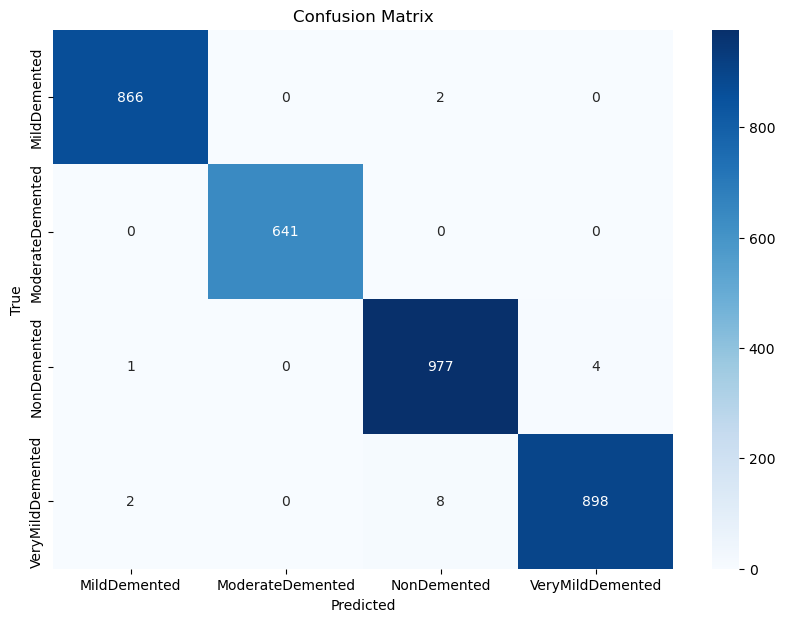

In [19]:
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.dataset.classes, yticklabels=test_loader.dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

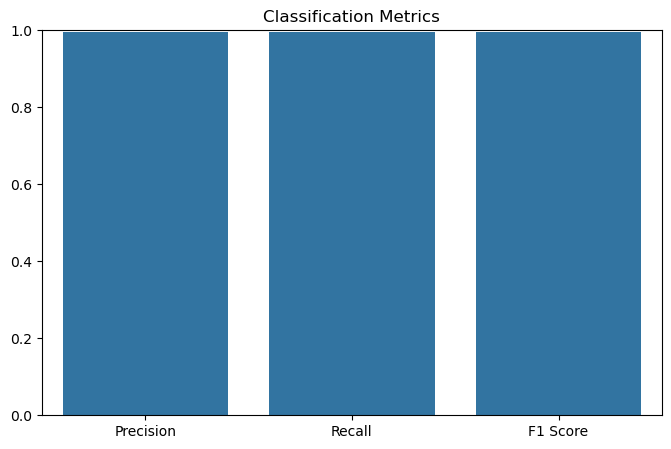

In [20]:
# Plotting Precision, Recall, and F1 Score
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(8, 5))
sns.barplot(x=metric_names, y=metrics)
plt.ylim(0, 1)
plt.title('Classification Metrics')
plt.show()

In [26]:
# Extract class-wise metrics
class_report = classification_report(all_labels, all_predictions, target_names=test_loader.dataset.dataset.classes, output_dict=True)
class_metrics = {class_name: class_report[class_name] for class_name in test_loader.dataset.dataset.classes}

In [27]:
# Print class-wise metrics
for class_name, metrics in class_metrics.items():
    print(f"\nClass: {class_name}")
    print(f"")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1-score']:.4f}")
    print(f"  Support: {metrics['support']}")


Class: MildDemented

  Precision: 0.9965
  Recall: 0.9977
  F1 Score: 0.9971
  Support: 868.0

Class: ModerateDemented

  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  Support: 641.0

Class: NonDemented

  Precision: 0.9899
  Recall: 0.9949
  F1 Score: 0.9924
  Support: 982.0

Class: VeryMildDemented

  Precision: 0.9956
  Recall: 0.9890
  F1 Score: 0.9923
  Support: 908.0


In [23]:
# Plotting class-wise metrics
class_names = list(class_metrics.keys())
class_precision = [metrics['precision'] for metrics in class_metrics.values()]
class_recall = [metrics['recall'] for metrics in class_metrics.values()]
class_f1 = [metrics['f1-score'] for metrics in class_metrics.values()]

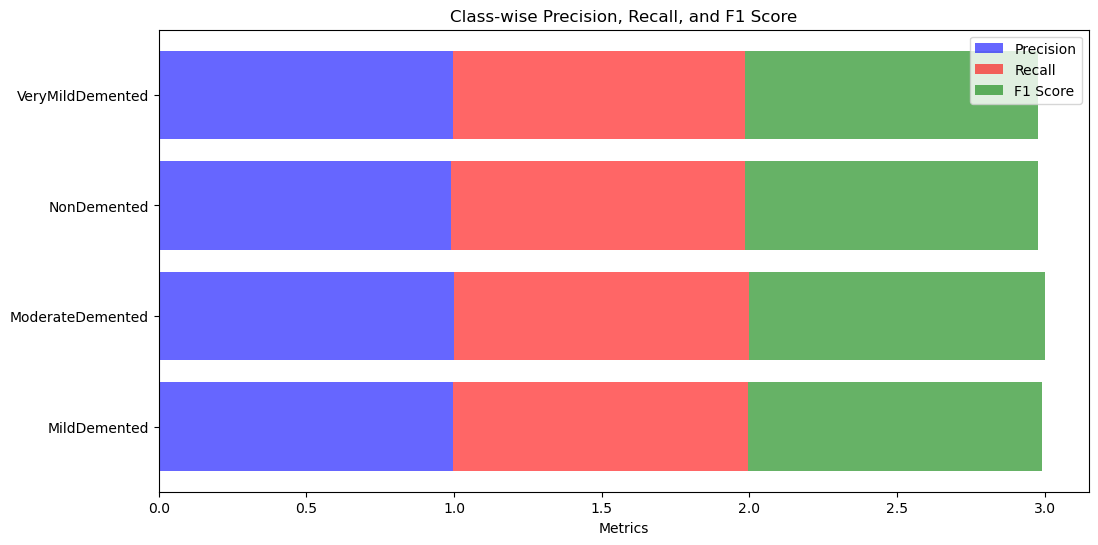

In [24]:
plt.figure(figsize=(12, 6))
plt.barh(class_names, class_precision, color='b', alpha=0.6, label='Precision')
plt.barh(class_names, class_recall, left=class_precision, color='r', alpha=0.6, label='Recall')
plt.barh(class_names, class_f1, left=[i+j for i,j in zip(class_precision, class_recall)], color='g', alpha=0.6, label='F1 Score')
plt.xlabel('Metrics')
plt.title('Class-wise Precision, Recall, and F1 Score')
plt.legend()
plt.show()